In [171]:
import pandas as pd
import plotnine as p9


In [172]:
df_md = pd.read_csv("the-movies-dataset/keywords.csv")
df_movie_keywords = []

for index, df_row in df_md.iterrows():
    movie_id = df_row["id"]
    keywords_json = df_row["keywords"]
    keywords_json = keywords_json.replace("\\xa0", " ")
    keywords_json = eval(keywords_json)

    for keyword in keywords_json:
        keyword_id = keyword["id"]
        keyword_name = keyword["name"]

        df_movie_keywords.append(
            {
                "movie_id": movie_id,
                "keyword_id": keyword_id,
                "keyword_name": keyword_name,
            },
        )

df_movie_keywords = pd.DataFrame(df_movie_keywords)
df_movie_keywords.head()


,movie_id,keyword_id,keyword_name
0,862,931,jealousy
1,862,4290,toy
2,862,5202,boy
3,862,6054,friendship
4,862,9713,friends


In [173]:
def json_array_to_values(json_array):
    json_array = json_array.replace("\\xa0", " ")
    json_array = eval(json_array)

    values = []
    for genre in json_array:
        values.append(genre["name"])

    return values


In [174]:
df_md = pd.read_csv("the-movies-dataset/movies_metadata.csv")
drop_columns = [
    "adult",
    "belongs_to_collection",
    "homepage",
    "imdb_id",
    "original_title",
    "overview",
    "poster_path",
    "status",
    "tagline",
    "video",
    "spoken_languages",
    "production_companies",
]

df_md.drop(drop_columns, axis=1, inplace=True)

# Convert the release_date column to year, month and day
df_md = df_md[df_md["release_date"].str.len() == 10]
df_md["release_date"] = pd.to_datetime(df_md["release_date"])
df_md["release_year"] = df_md["release_date"].dt.year
df_md["release_month"] = df_md["release_date"].dt.month
df_md["release_day"] = df_md["release_date"].dt.day
df_md = df_md[df_md["release_year"] >= 1980]
df_md = df_md[df_md["release_year"] <= 2015]

df_md.drop("release_date", axis=1, inplace=True)


numeric_columns = [
    "id",
    "budget",
    "revenue",
    "runtime",
    "popularity",
    "vote_average",
    "vote_count",
    "release_year",
    "release_month",
    "release_day",
]

for column in numeric_columns:
    df_md[column] = pd.to_numeric(df_md[column], errors="coerce")

df_md.dropna(subset=numeric_columns, inplace=True)

# Convert the json columns to arrays
df_md["genres"] = df_md["genres"].apply(lambda x: json_array_to_values(x))
df_md["production_countries"] = df_md["production_countries"].apply(lambda x: json_array_to_values(x))


/var/folders/s0/tqtx5tfn21b8rys89pkqht4m0000gn/T/ipykernel_72995/2113749326.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


In [175]:
df_kw = pd.read_csv("the-movies-dataset/keywords.csv")

df_kw["id"] = pd.to_numeric(df_kw["id"], errors="coerce")
df_kw.dropna(subset=["id"], inplace=True)

df_kw["keywords"] = df_kw["keywords"].apply(lambda x: json_array_to_values(x))


In [305]:
df_main = pd.merge(df_md, df_kw, left_on="id", right_on="id", how="left")
df_main.head().transpose()


,0,1,2,3,4
budget,30000000,65000000,0,16000000,0
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]","[Comedy, Drama, Romance]",[Comedy]
id,862,8844,15602,31357,11862
original_language,en,en,en,en,en
popularity,21.946943,17.015539,11.7129,3.859495,8.387519
production_countries,[United States of America],[United States of America],[United States of America],[United States of America],[United States of America]
revenue,373554033.0,262797249.0,0.0,81452156.0,76578911.0
runtime,81.0,104.0,101.0,127.0,106.0
title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
vote_average,7.7,6.9,6.5,6.1,5.7


In [177]:
",".join(list(df_main.columns))


'budget,genres,id,original_language,popularity,production_countries,revenue,runtime,title,vote_average,vote_count,release_year,release_month,release_day,keywords'

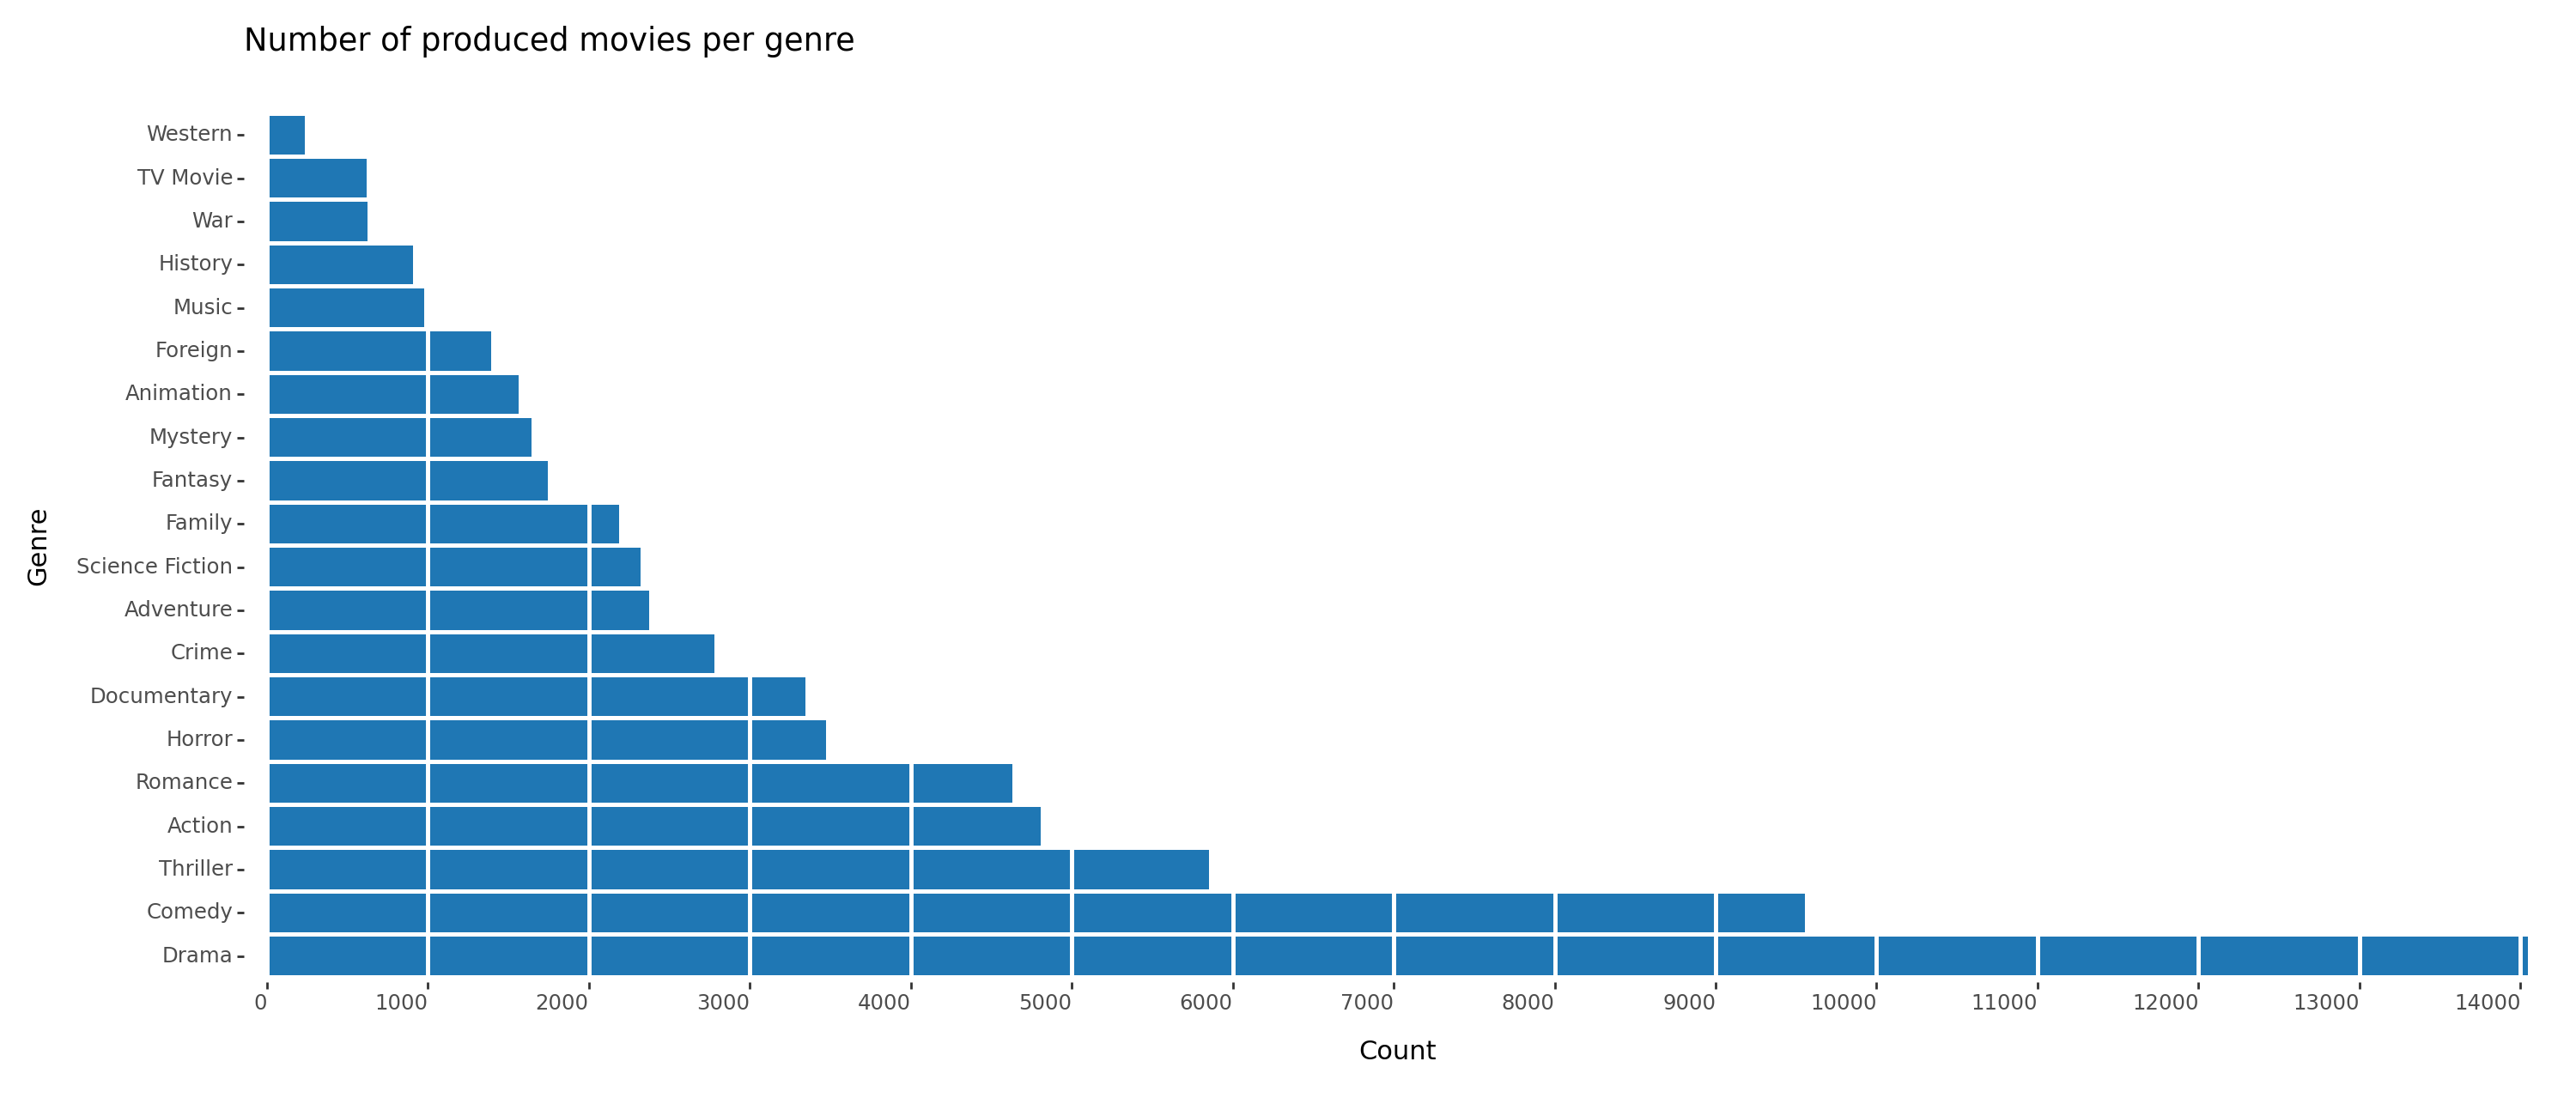

In [285]:
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = df_genres.groupby("genres").size().reset_index(name="count")
df_genres_count = df_genres_count.sort_values(by="count", ascending=False)

p = (
    p9.ggplot(df_genres_count, p9.aes('reorder(genres, -count)', 'count', fill='genres'))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#ffffff', size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 15000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)
p.draw()


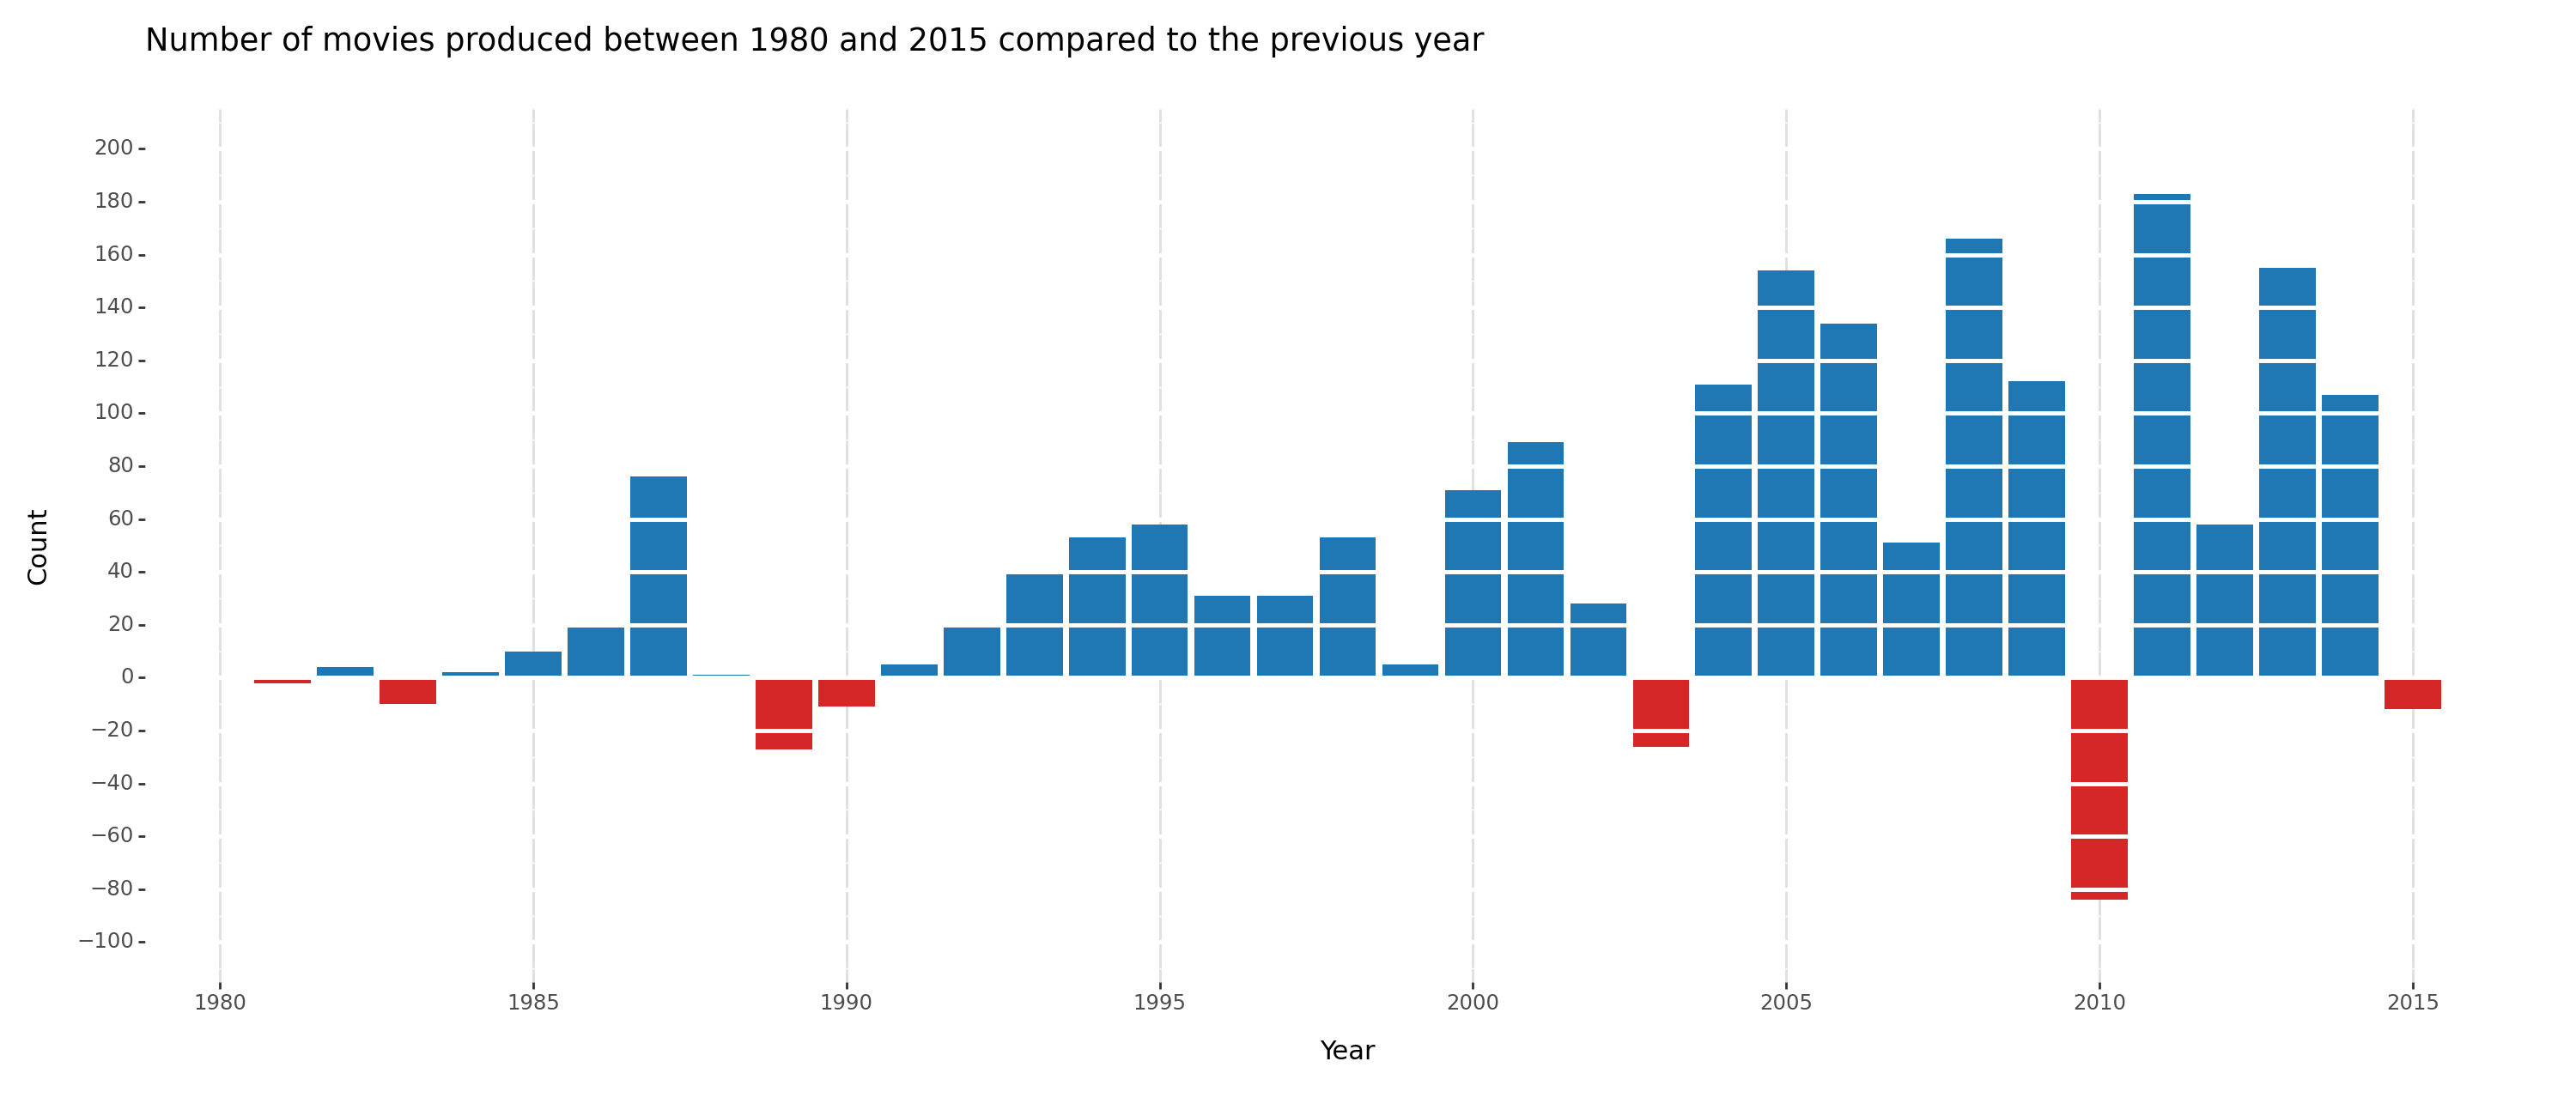

In [302]:
# Let's now see how the number of movies produced per year has evolved.
df_year_count = df_main.groupby("release_year").size().reset_index(name="count")
df_year_count = df_year_count.sort_values(by="release_year", ascending=True)
df_year_count["count"] = df_year_count["count"].astype(int)

df_year_count["count"] = df_year_count["count"].diff()
df_year_count = df_year_count.dropna(subset=["count"])
df_year_count["count"] = df_year_count["count"].astype(int)

p = (
    p9.ggplot(df_year_count, p9.aes('release_year', 'count'))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(data=df_year_count[df_year_count["count"] < 0], stat="identity", fill="#d62728")
    + p9.labs(x="Year", y="Count", title="Number of movies produced between 1980 and 2015 compared to the previous year")
    + p9.scale_x_continuous(breaks=range(1970, 2016, 5))
    + p9.scale_y_continuous(breaks=range(-100, 210, 20), expand=(0.05, 0.05))
    + p9.geom_hline(yintercept=range(-100, 210, 20), color="#ffffff", size=1)
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


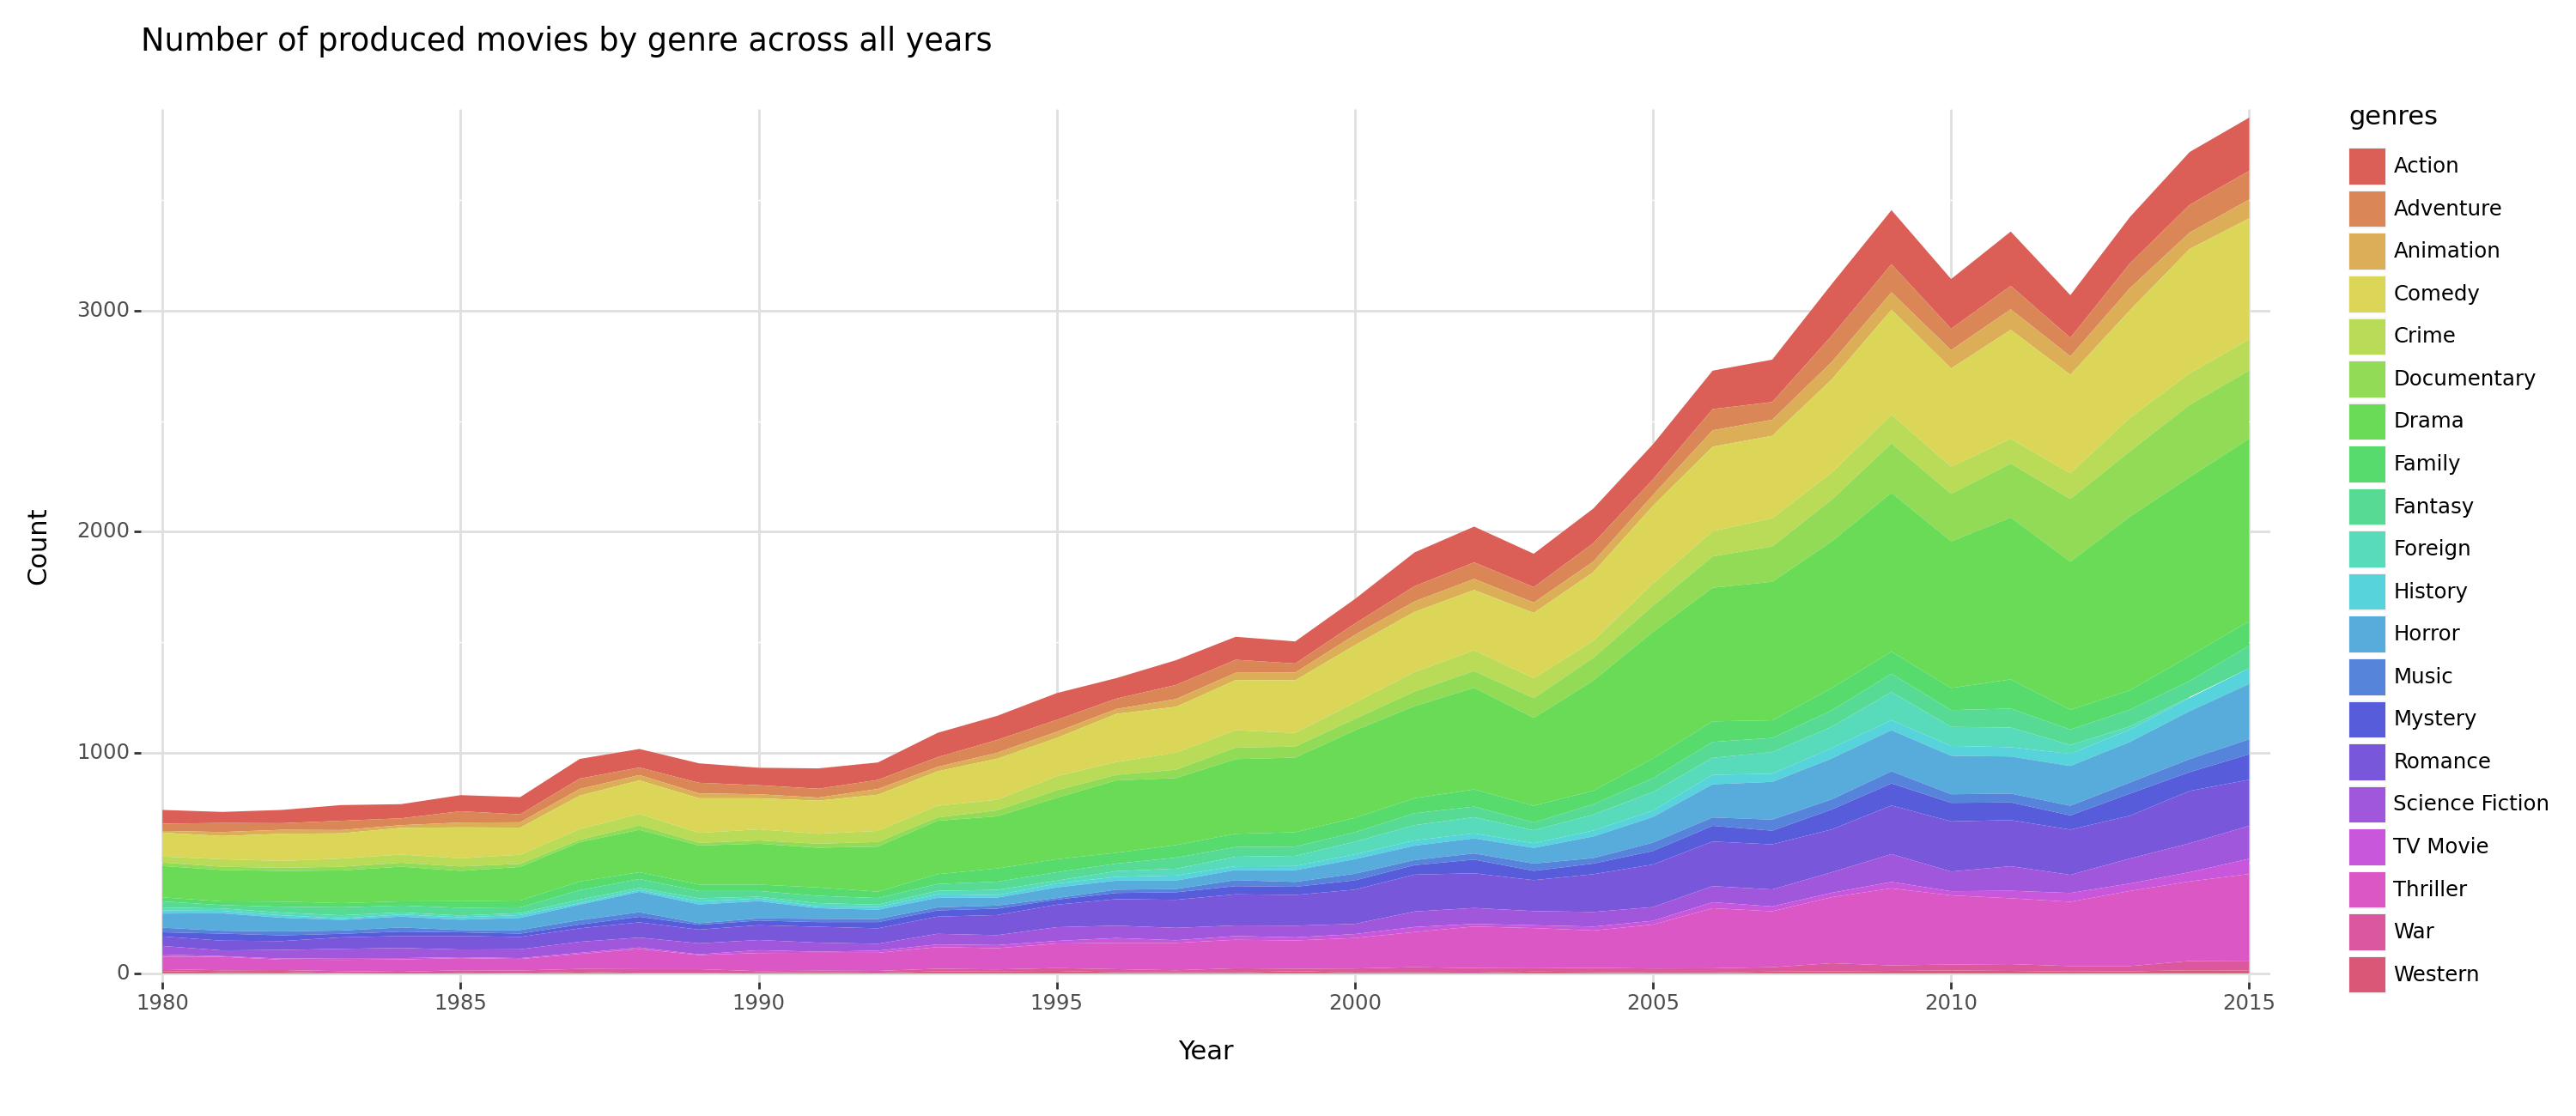

In [360]:
# Total number of produced movies by genre across all years as a stacked area chart.
df_genres_year_count = df_main.explode("genres")
df_genres_year_count = df_genres_year_count.dropna(subset=["genres"])
df_genres_year_count["genres"] = df_genres_year_count["genres"].str.strip()

df_genres_year_count = df_genres_year_count.groupby(["release_year", "genres"]).size().reset_index(name="count")
df_genres_year_count = df_genres_year_count.sort_values(by="release_year", ascending=True)
df_genres_year_count["count"] = df_genres_year_count["count"].astype(int)

p = (
    p9.ggplot(df_genres_year_count, p9.aes('release_year', 'count', fill='genres'))
    + p9.geom_area()
    + p9.labs(x="Year", y="Count", title="Number of produced movies by genre across all years")
    + p9.scale_x_continuous(breaks=range(1970, 2016, 5), expand=(0.01, 0.01))
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


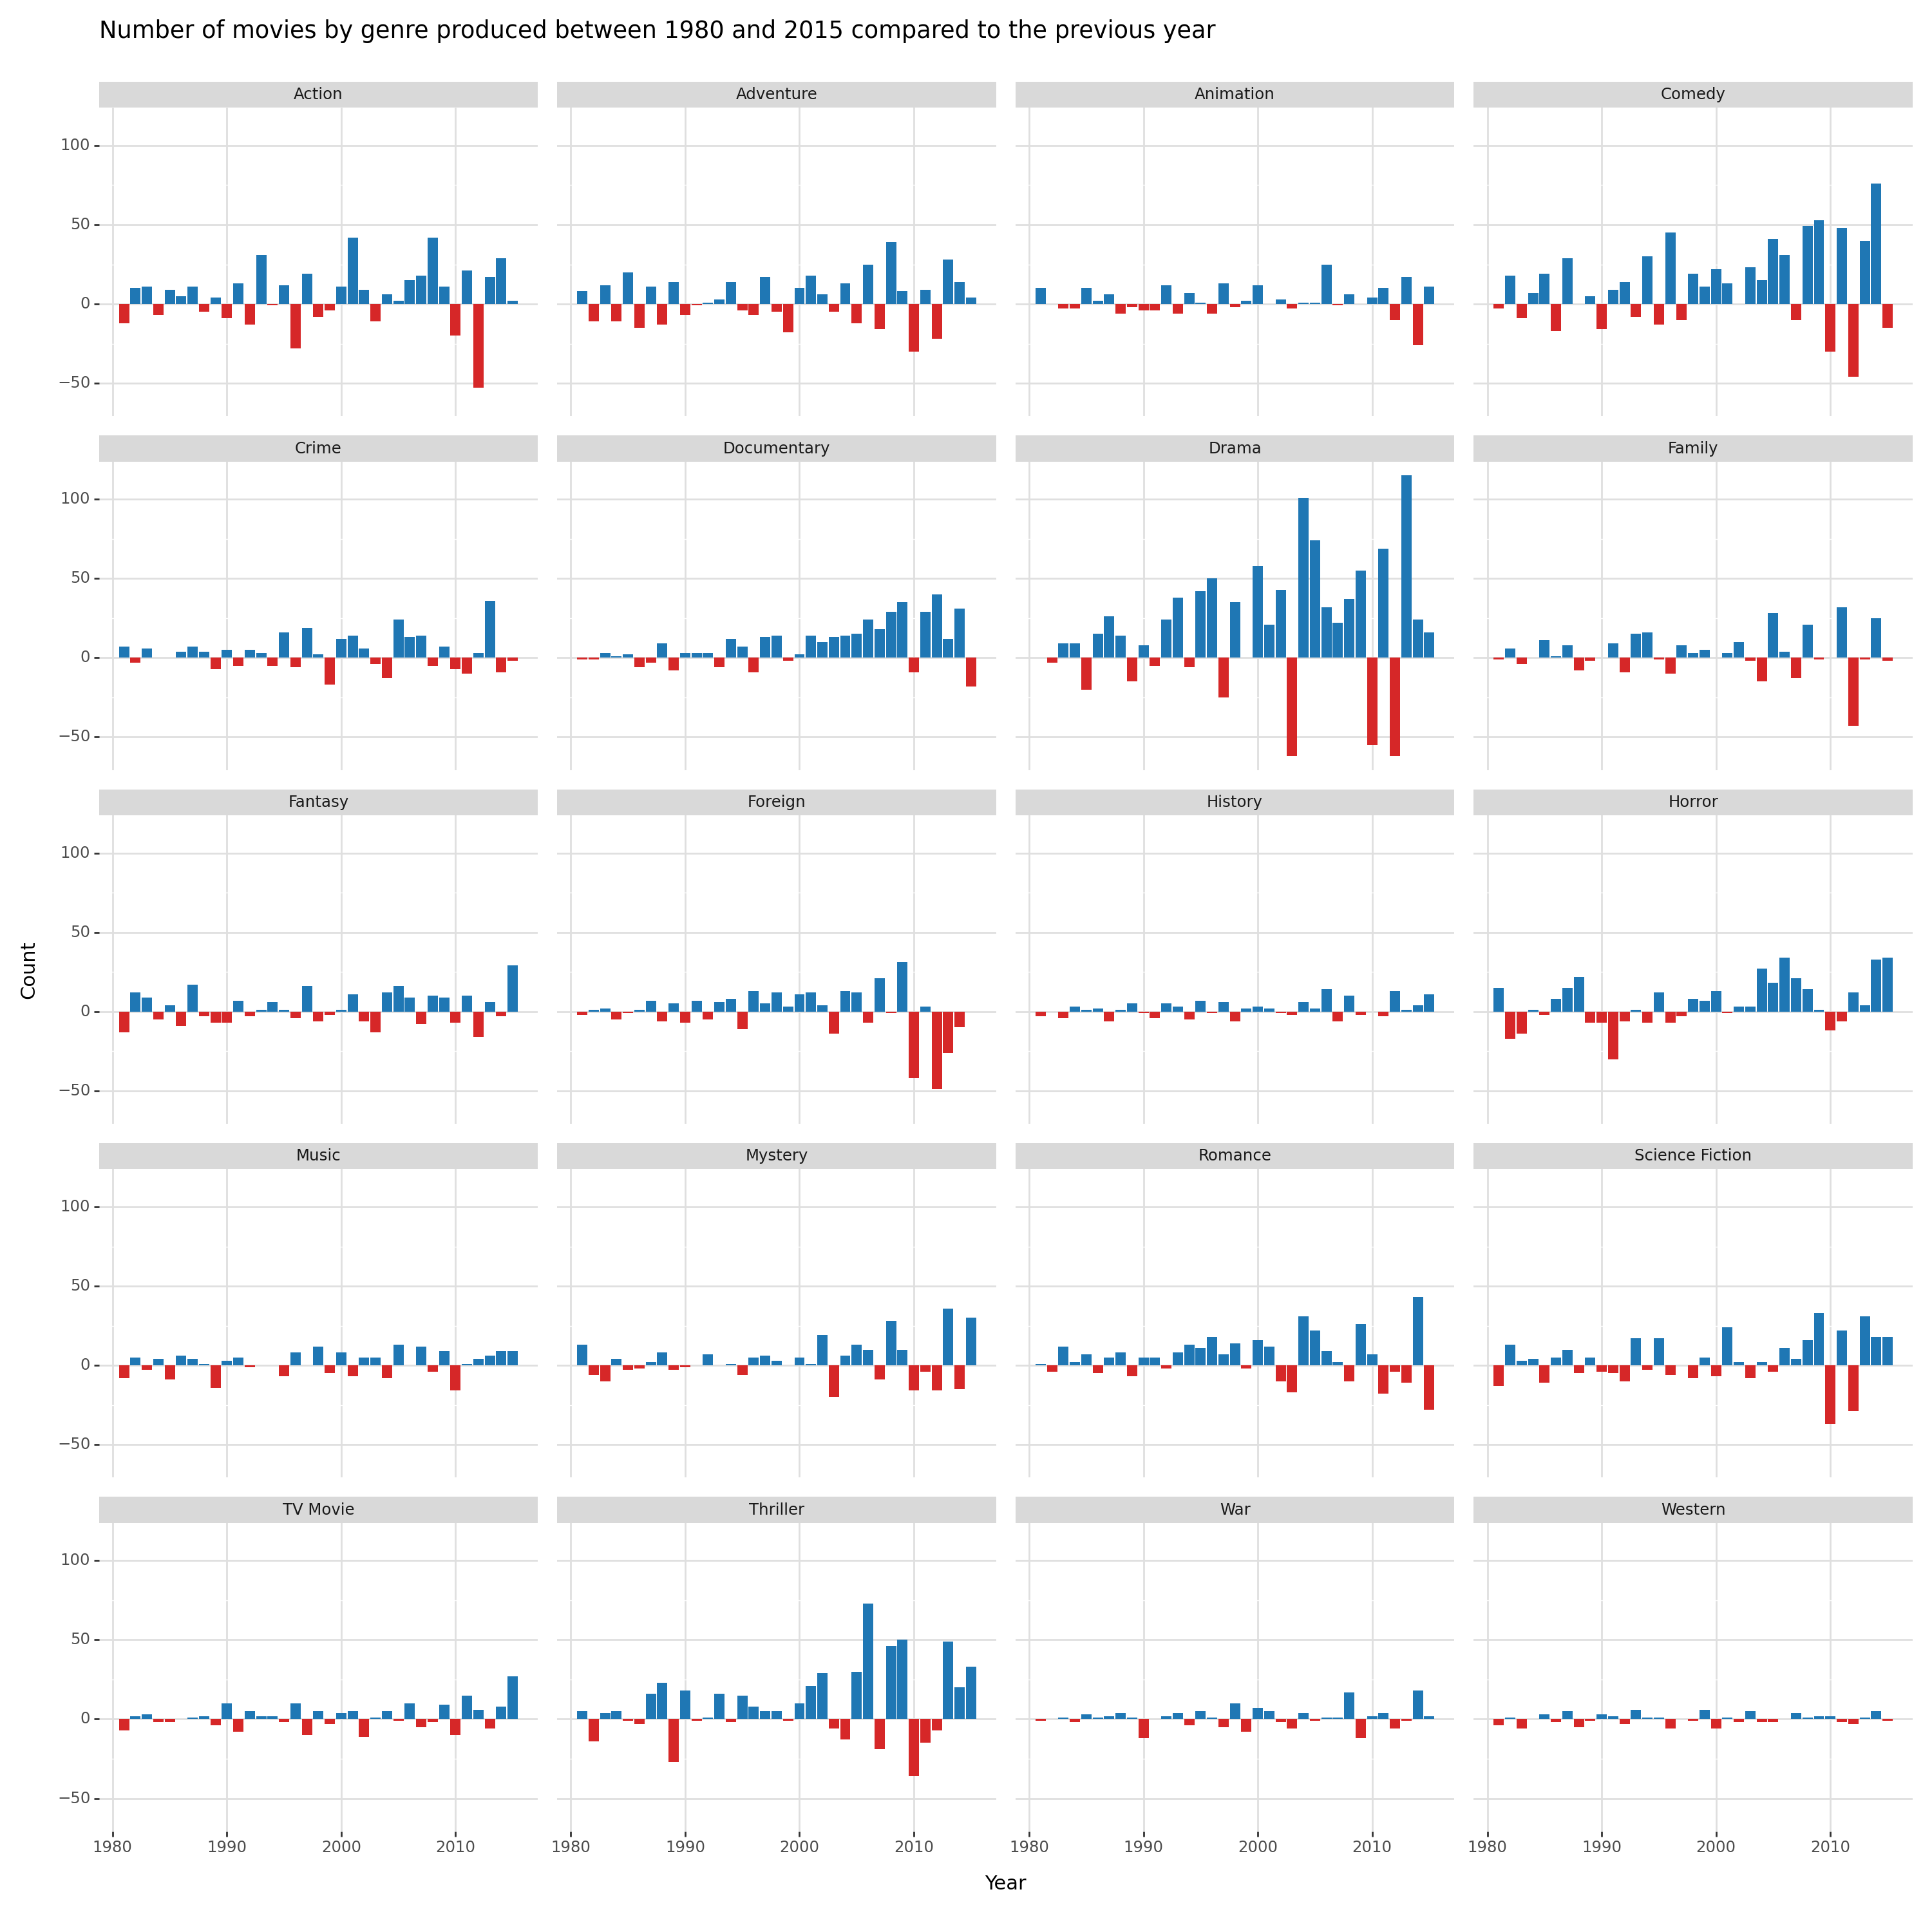

In [286]:
# Let's do a re-expression of the number of movies by genre. We will use the increase per year as a metric.
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = df_genres.groupby(["genres", "release_year"]).size().reset_index(name="count")
df_genres_count = df_genres_count.sort_values(by=["genres", "release_year"], ascending=True)
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count.groupby("genres")["count"].diff()
df_genres_count = df_genres_count.dropna(subset=["count"])
df_genres_count["count"] = df_genres_count["count"].astype(int)

p = (
    p9.ggplot(df_genres_count, p9.aes('release_year', 'count'))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(data=df_genres_count[df_genres_count["count"] < 0], stat="identity", fill="#d62728")
    + p9.labs(x="Year", y="Count", title="Number of movies by genre produced between 1980 and 2015 compared to the previous year")
    + p9.scale_x_continuous(breaks=range(1970, 2016, 10))
    + p9.facet_wrap("genres", ncol=4, scales="fixed", labeller="label_context")
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


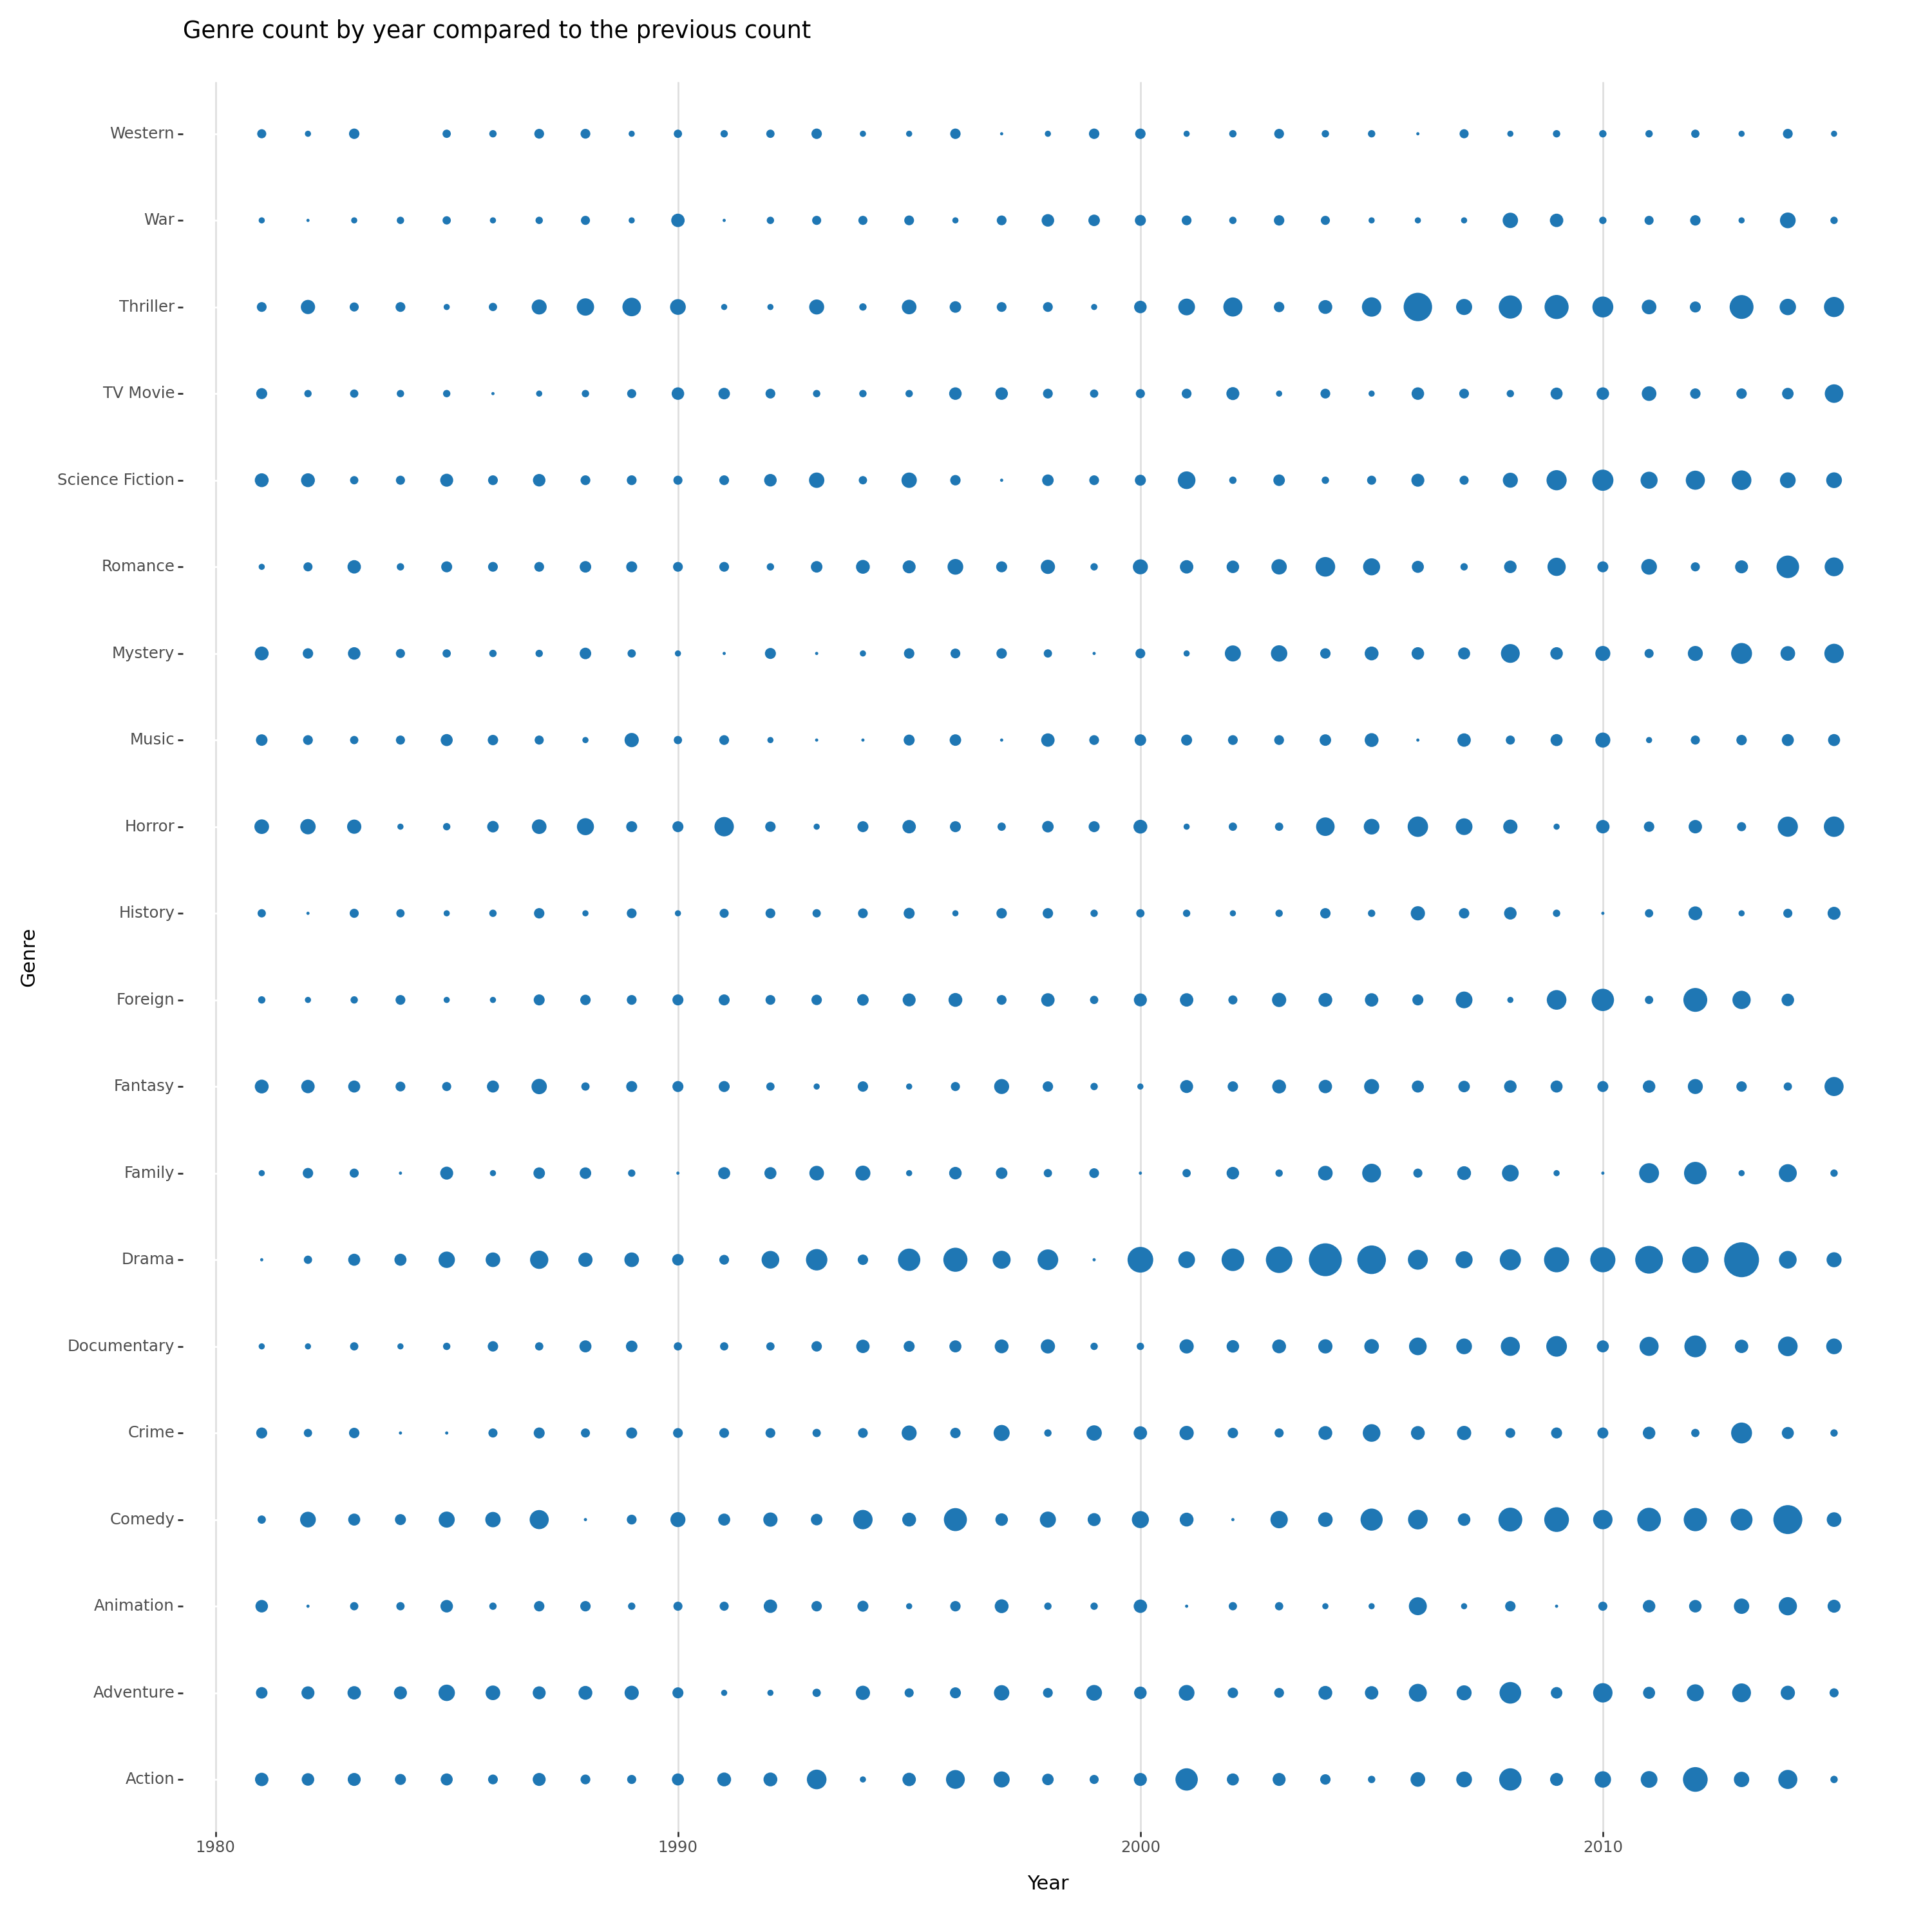

In [314]:
# Genre count by year re-expression

df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = df_genres.groupby(["genres", "release_year"]).size().reset_index(name="count")
df_genres_count = df_genres_count.sort_values(by=["genres", "release_year"], ascending=True)
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count.groupby("genres")["count"].diff()
df_genres_count = df_genres_count.dropna(subset=["count"])
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count["count"].abs()
df_genres_count["count"] = df_genres_count["count"] / df_genres_count["count"].max()
df_genres_count["count"] = df_genres_count["count"] * 100

p = (
    p9.ggplot(df_genres_count, p9.aes('release_year', 'genres', size='count'))
    + p9.geom_point(fill="#1f77b4", color="#1f77b4")
    + p9.labs(x="Year", y="Genre", title="Genre count by year compared to the previous count")
    + p9.scale_x_continuous(breaks=range(1970, 2016, 10))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.theme(
        figure_size=(15, 15),
        legend_position="none",
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major_x=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


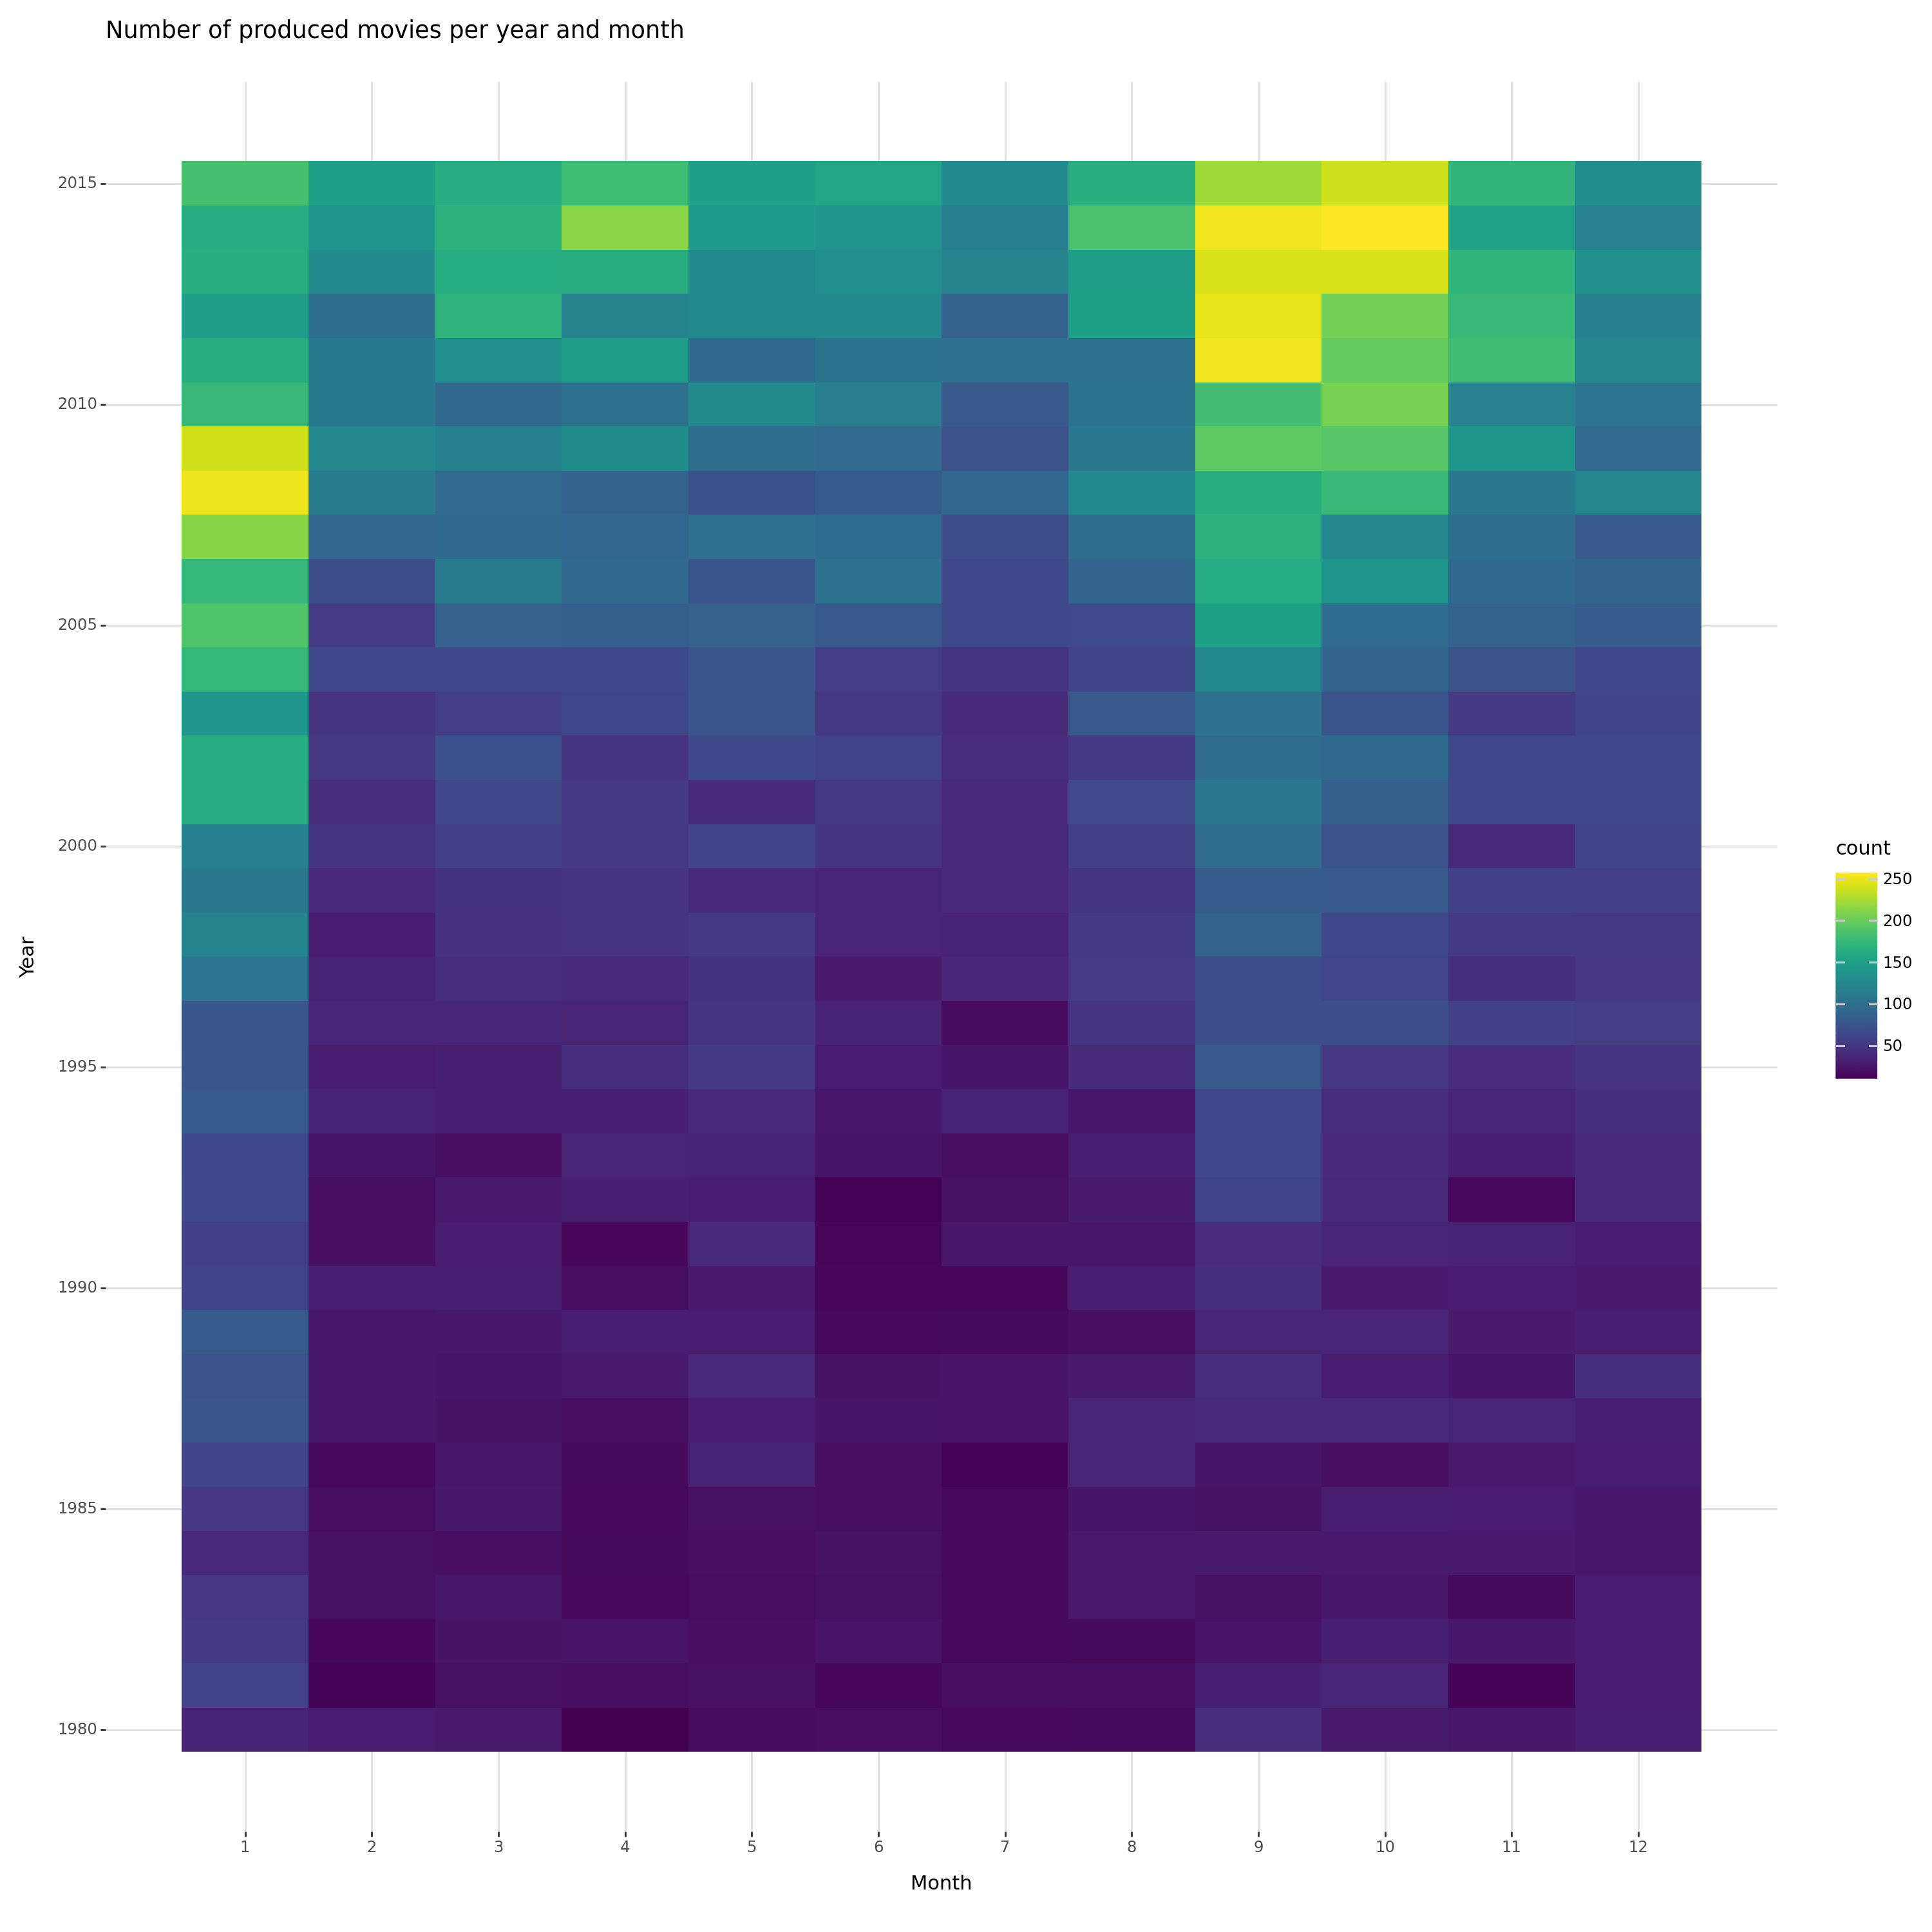

In [369]:
# Number of produced movies per year and month as tiles.
df_year_month_count = df_main.groupby(["release_year", "release_month"]).size().reset_index(name="count")
df_year_month_count = df_year_month_count.sort_values(by=["release_year", "release_month"], ascending=True)
df_year_month_count["count"] = df_year_month_count["count"].astype(int)

p = (
    p9.ggplot(df_year_month_count, p9.aes('release_month', 'release_year', fill='count'))
    + p9.geom_tile()
    + p9.labs(x="Month", y="Year", title="Number of produced movies per year and month")
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    + p9.scale_x_continuous(breaks=range(1, 13))
    + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


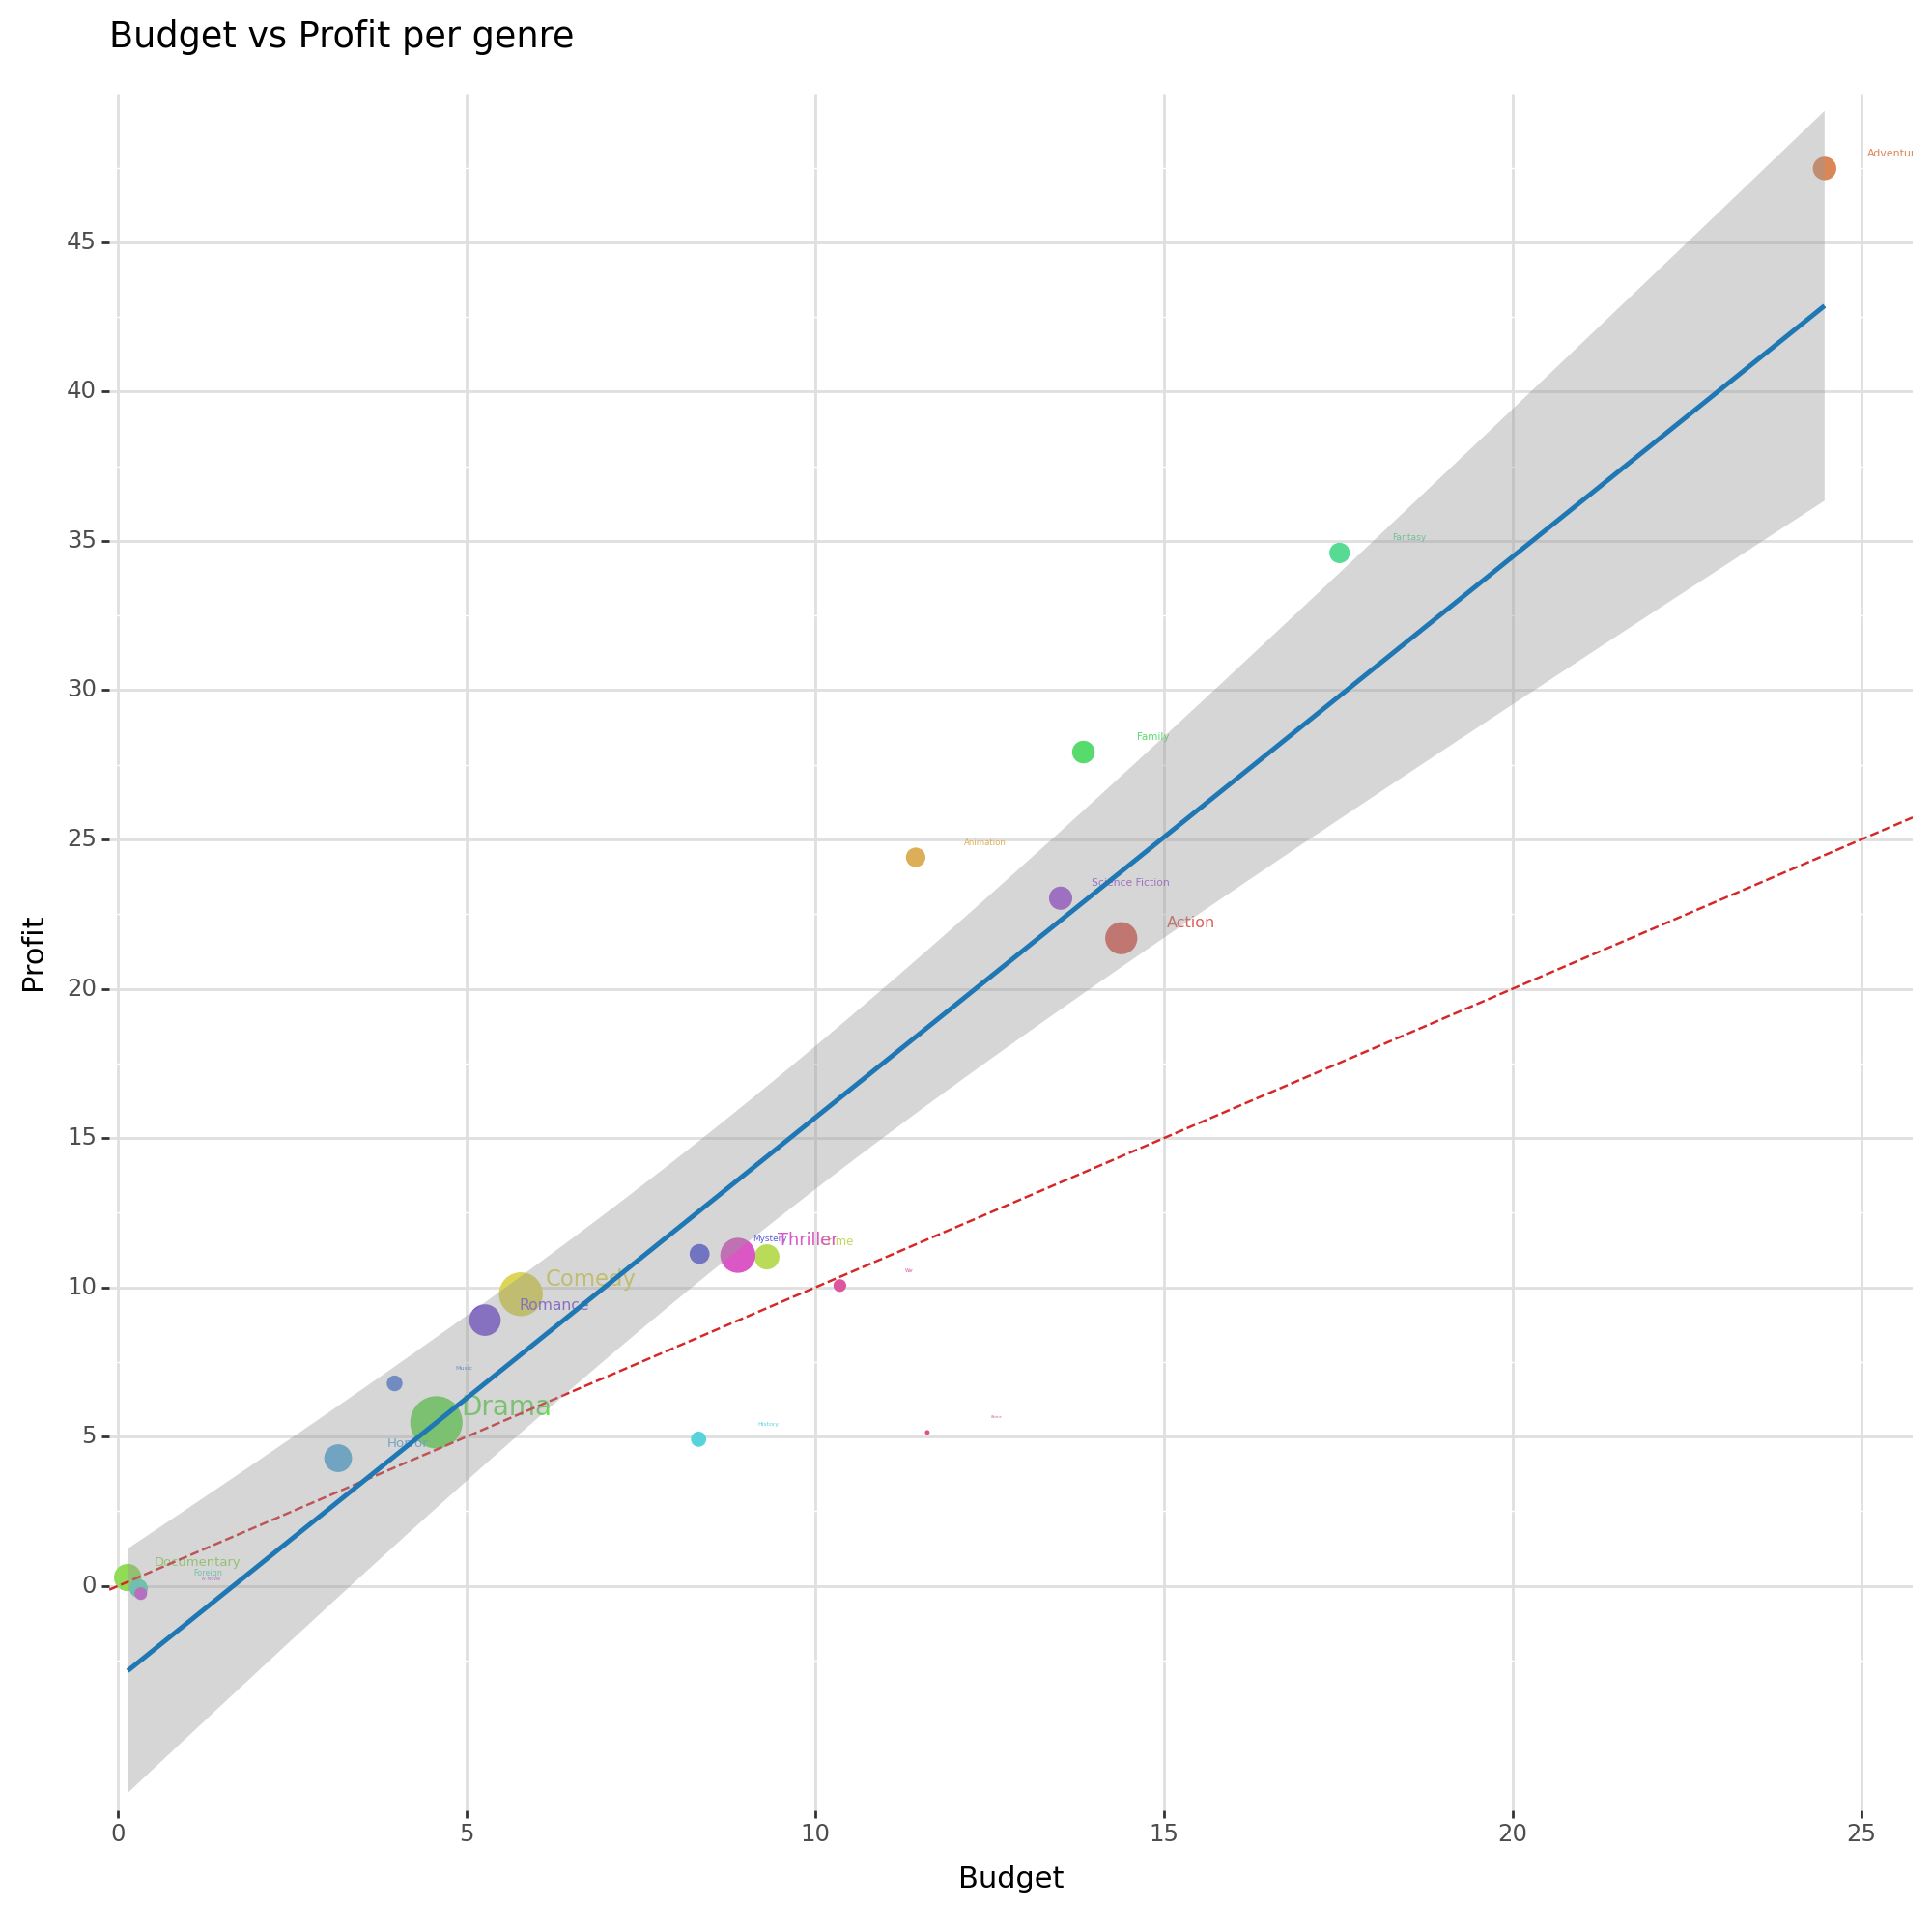

In [488]:
# For each genre we need to calculate the average budget, revenue and how many movies were produced.
# In the plot, the x-axis will be the budget, the y axis the profit, the size of the bubble will be the number of movies produced and the color will be the genre.
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()

df_genres = df_genres.groupby("genres").agg(
    {
        "budget": "mean",
        "revenue": "mean",
        "id": "count",
    }
).reset_index()

df_genres["profit"] = df_genres["revenue"] - df_genres["budget"]
df_genres["budget"] = df_genres["budget"] / 1000000
df_genres["revenue"] = df_genres["revenue"] / 1000000
df_genres["profit"] = df_genres["profit"] / 1000000

p = (
    p9.ggplot(df_genres, p9.aes('budget', 'profit', size='id', color='genres'))
    + p9.geom_point()
    + p9.labs(x="Budget", y="Profit", title="Budget vs Profit per genre")
    + p9.scale_x_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_y_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.geom_text(p9.aes(label="genres"), nudge_x=1, nudge_y=0.5)
    + p9.geom_abline(intercept=0, slope=1, linetype="dashed", color="#d62728", show_legend=True)
    + p9.geom_smooth(method="lm", color="#1f77b4", se=True, show_legend=True, fullrange=True)
    + p9.guides(size=False, color=False)
    + p9.theme(
        figure_size=(10, 10),
        legend_position="",
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


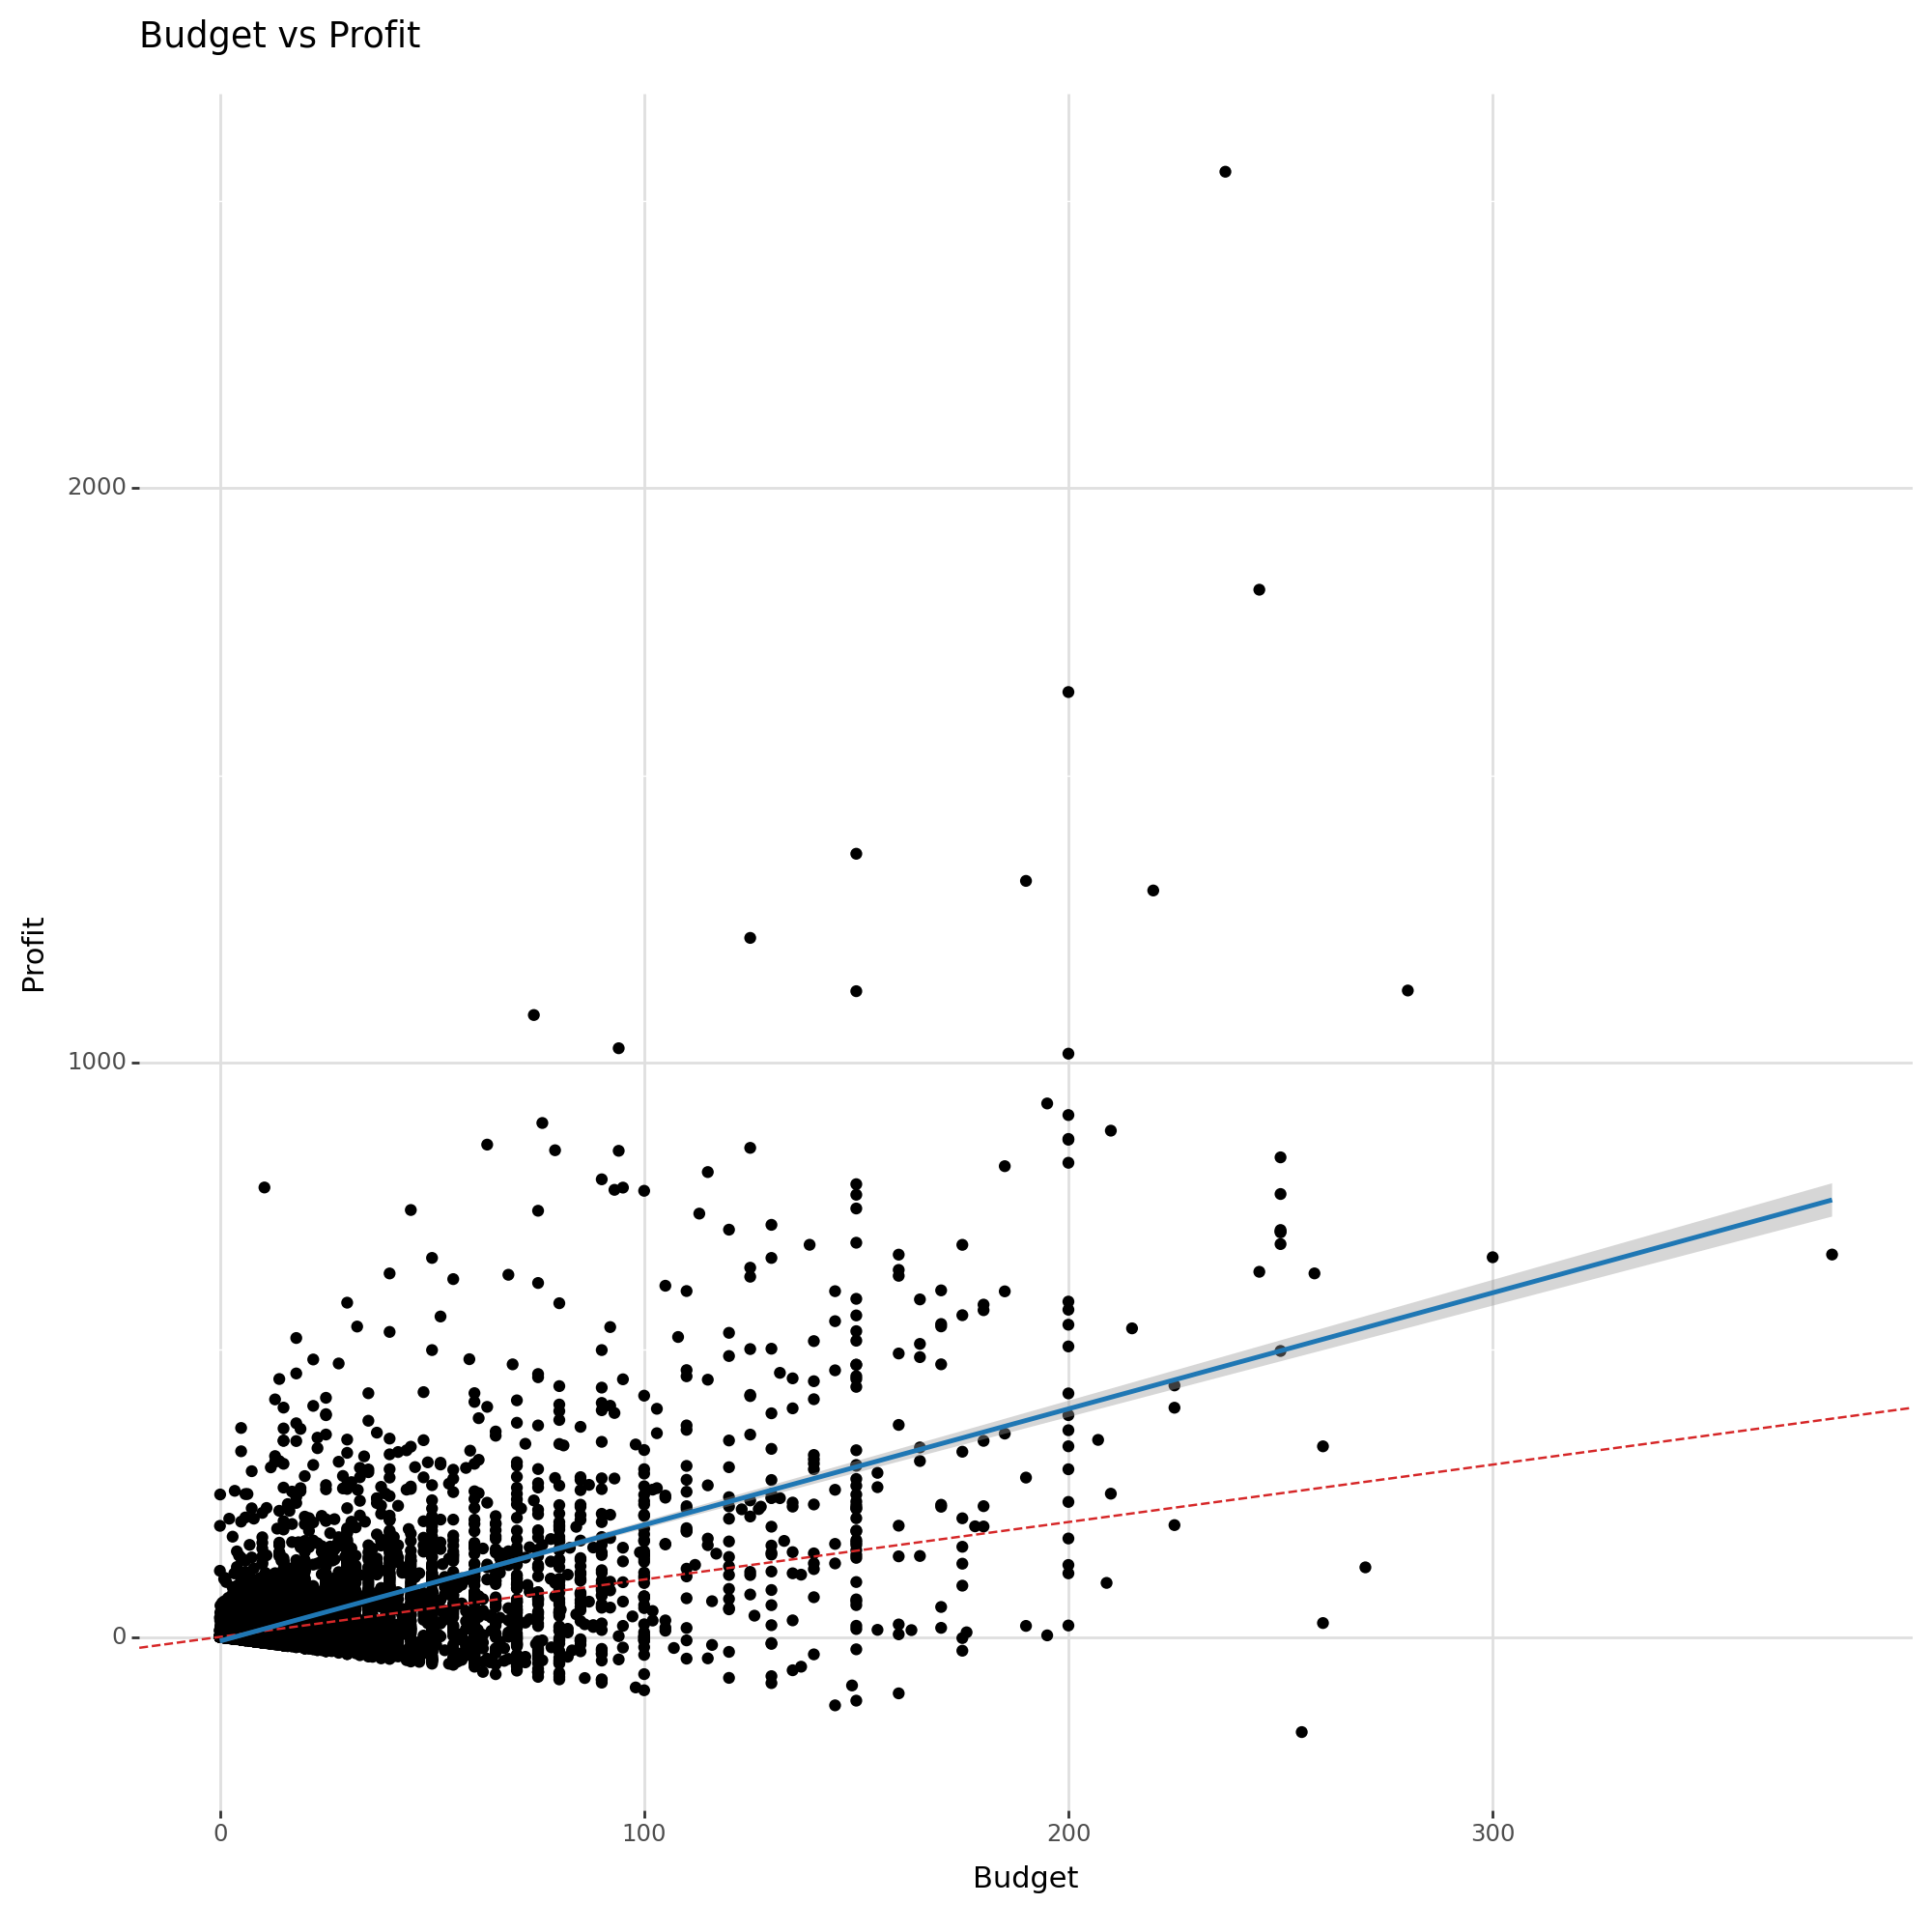

In [491]:
# For each movie calculate the relationship between the budget and the revenue if they are present and greater than 0. Use another df instead of df_main
df_temp = df_main[["budget", "revenue"]]
# drop rows with null values
df_temp = df_temp.dropna()
# drop rows with 0 values
df_temp = df_temp[df_temp["budget"] > 0]
df_temp = df_temp[df_temp["revenue"] > 0]
df_temp["budget"] = df_temp["budget"] / 1000000
df_temp["revenue"] = df_temp["revenue"] / 1000000
df_temp["profit"] = df_temp["revenue"] - df_temp["budget"]

p = (
    p9.ggplot(df_temp, p9.aes('budget', 'profit'))
    + p9.geom_point()
    + p9.labs(x="Budget", y="Profit", title="Budget vs Profit")
    # + p9.scale_x_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    # + p9.scale_y_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.geom_abline(intercept=0, slope=1, linetype="dashed", color="#d62728", show_legend=True)
    + p9.geom_smooth(color="#1f77b4", se=True, show_legend=True, fullrange=True)
    + p9.theme(
        figure_size=(10, 10),
        legend_position="",
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#dfdfdf', size=1),
    )
)
p.draw()


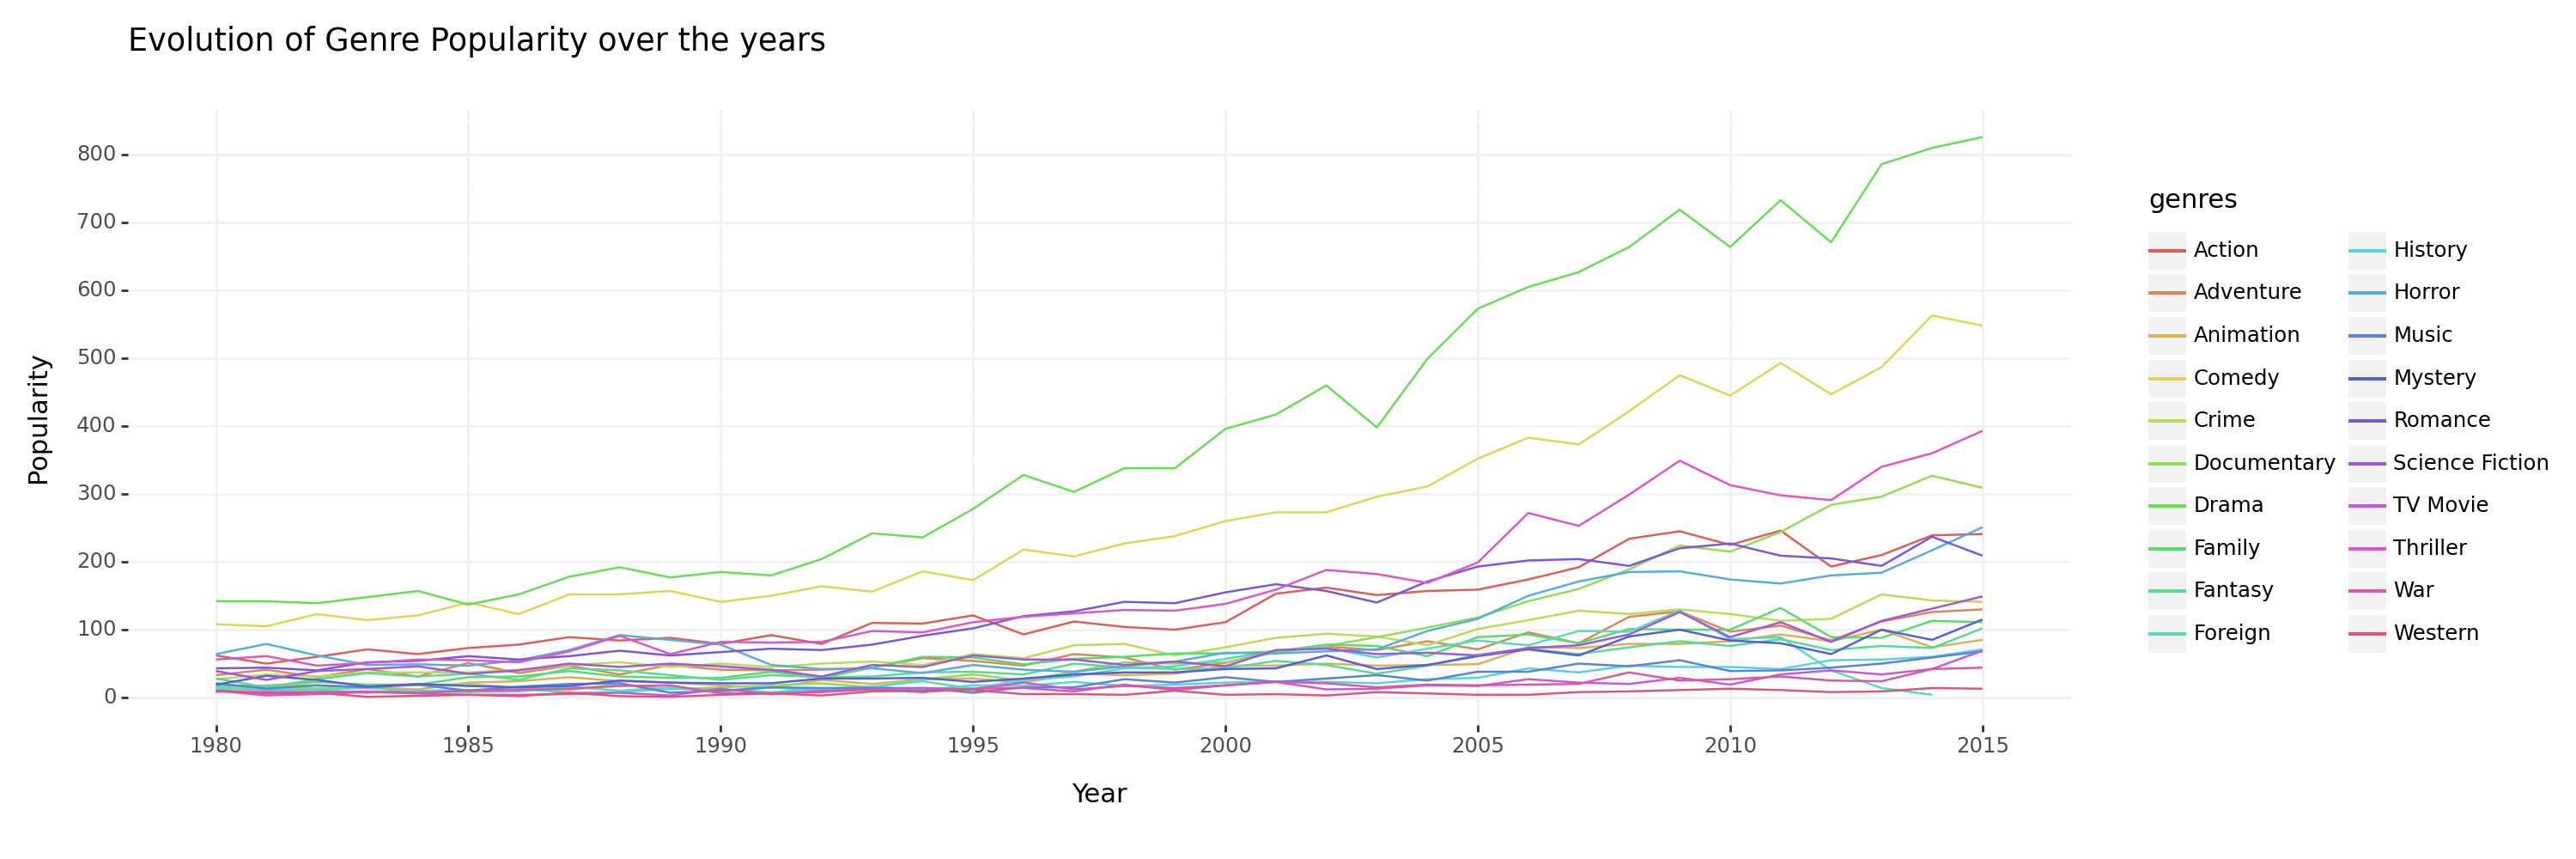

In [ ]:
import plotnine as p9
# From here on we will not modify any data in the df_main. Instead we will create
# new dataframes and use them for visualization.

# Visualization 1: Evolution of Genre Popularity over the years

# Our first stop on this cinematic odyssey was a stroll through the annals of movie genres.
# The visual data told a captivating story of changing audience tastes. While classics
# such as Drama and Comedy maintained their charm, we observed an intriguing surge in the
# popularity of Adventure and Science Fiction genres, marking a shift in cinematic preferences
# through the decades. Action-packed plots and cosmic adventures enthralled
# audiences in the 21st century.

df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()

df_genres = df_genres.groupby(["release_year", "genres"]).size().reset_index(name="count")
# rank the genres by their popularity
df_genres["rank"] = df_genres.groupby(["release_year"])["count"].rank("dense", ascending=False)

plot = (
        p9.ggplot(df_genres, p9.aes(x="release_year", y="count", color="genres"))
        + p9.scale_x_continuous(breaks=range(1980, 2020, 5))
        + p9.scale_y_continuous(breaks=range(0, 1000, 100))
        + p9.geom_line()
        + p9.labs(
            title="Evolution of Genre Popularity over the years",
            x="Year",
            y="Popularity",
        )
        + p9.theme(
            axis_text_x=p9.element_text(rotation=0),
            figure_size=(15, 5),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='#f1f1f1'),
        )
        + p9.guides(color=p9.guide_legend(ncol=2))
    )

plot.draw()
